In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [2]:
import gym
from gym import spaces
import random
from collections import deque, defaultdict

In [3]:
from glob import glob

In [4]:
# Load the dataset
file_path1 = glob(f"datasets/v3/day*.csv")
file_path2 = glob(f"datasets/v3/poison*.csv")

In [5]:
file_path2[0][18:]

'14.csv'

In [6]:
file_path1 = sorted(file_path1, key=lambda x: int(x[15:].split('.')[0]))

In [7]:
file_path1

['datasets/v3/day8.csv',
 'datasets/v3/day9.csv',
 'datasets/v3/day10.csv',
 'datasets/v3/day11.csv',
 'datasets/v3/day12.csv',
 'datasets/v3/day13.csv',
 'datasets/v3/day14.csv']

In [8]:
file_path2 = sorted(file_path2, key=lambda x: int(x[18:].split('.')[0]))
file_path2

['datasets/v3/poison8.csv',
 'datasets/v3/poison9.csv',
 'datasets/v3/poison10.csv',
 'datasets/v3/poison11.csv',
 'datasets/v3/poison12.csv',
 'datasets/v3/poison13.csv',
 'datasets/v3/poison14.csv']

In [9]:
data1 = [pd.read_csv(x) for x in file_path1]
data2 = [pd.read_csv(x) for x in file_path2]

In [10]:
def preprocess_data(df):
    # Convert 'Weapon Detected' to binary (1 for 'Yes', 0 for 'No')
    #df['Weapon Detected'] = df['Weapon Detected'].apply(lambda x: 1 if x == 'Yes' else 0)

    # Encode 'Timestamp' using LabelEncoder
    label_encoder = LabelEncoder()
    df['Hour'] = label_encoder.fit_transform(df['Hour'])
    
    week_label = LabelEncoder()
    df['Weekday/Weekend'] = week_label.fit_transform(df['Weekday/Weekend'])

    # Extract state and action data
    state_data = df[['Hour', 'Presence Detector', 'Face Recognition', 'Weapon Recognition']].values
    actions = df['Action'].values
    
    return state_data, actions

In [11]:
# Preprocess the dataset
#state_data_N, actions_N = preprocess_data(data1)
state_data_N = []
actions_N = []
for d in data1:
    a, b = preprocess_data(d)
    state_data_N.append(a)
    actions_N.append(b)
    

In [12]:
state_data_N

[array([[  0,   0,   0,   0],
        [  1,   0,   0,   0],
        [  2,   0,   0,   0],
        [  3,   0,   0,   0],
        [  4,   0,   0,   0],
        [  5,   0,   0,   0],
        [  6,   0,   0,   0],
        [  7,   0,   0,   0],
        [  8,   0,   0,   0],
        [  9,   0,   0,   0],
        [ 10,   0,   0,   0],
        [ 11,   0,   0,   0],
        [ 12,   0,   0,   0],
        [ 13,   0,   0,   0],
        [ 14,   0,   0,   0],
        [ 15,   0,   0,   0],
        [ 16,   0,   0,   0],
        [ 17,   0,   0,   0],
        [ 18,   0,   0,   0],
        [ 19,   0,   0,   0],
        [ 20,   0,   0,   0],
        [ 21,   0,   0,   0],
        [ 22,   0,   0,   0],
        [ 23,   0,   0,   0],
        [ 24,   0,   0,   0],
        [ 25,   0,   0,   0],
        [ 26,   0,   0,   0],
        [ 27,   0,   0,   0],
        [ 28,   0,   0,   0],
        [ 29,   0,   0,   0],
        [ 30,   0,   0,   0],
        [ 31,   0,   0,   0],
        [ 32,   0,   0,   0],
        [ 

In [13]:
state_data_N[6]

array([[  0,   1,   4,   0],
       [  1,   1,   4,   0],
       [  2,   1,   4,   0],
       [  3,   1,   4,   0],
       [  4,   1,   4,   0],
       [  5,   1,   4,   0],
       [  6,   1,   4,   0],
       [  7,   1,   4,   0],
       [  8,   1,   4,   0],
       [  9,   1,   4,   0],
       [ 10,   1,   4,   0],
       [ 11,   1,   4,   0],
       [ 12,   1,   4,   0],
       [ 13,   1,   4,   0],
       [ 14,   1,   4,   0],
       [ 15,   1,   4,   0],
       [ 16,   1,   4,   0],
       [ 17,   1,   4,   0],
       [ 18,   1,   4,   0],
       [ 19,   1,   4,   0],
       [ 20,   1,   4,   0],
       [ 21,   1,   4,   0],
       [ 22,   1,   4,   0],
       [ 23,   1,   4,   0],
       [ 24,   1,   4,   0],
       [ 25,   1,   4,   0],
       [ 26,   1,   4,   0],
       [ 27,   1,   4,   0],
       [ 28,   1,   4,   0],
       [ 29,   1,   4,   0],
       [ 30,   1,   4,   0],
       [ 31,   1,   4,   0],
       [ 32,   1,   4,   0],
       [ 33,   1,   4,   0],
       [ 34,  

In [14]:
len(state_data_N)

7

In [15]:
actions_N

[array(['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0', '1  # Intrusion detected', '1',
        '0  # Intruder leaves', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0  # Kids return home', '0', '0', '0', '0', '0',
        '0  # Parents return home', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0', '0', '0', '0  # Family goes to bed', '0', '0', '0',
        '0'], dtype=object),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [16]:
# Preprocess the dataset
#state_data_P, actions_P = preprocess_data(data2)
state_data_P = []
actions_P = []
for d in data2:
    a, b = preprocess_data(d)
    state_data_P.append(a)
    actions_P.append(b)
    

In [17]:
state_data_P

[array([[  0,   0,   0,   0],
        [  1,   0,   0,   0],
        [  2,   0,   0,   0],
        [  3,   0,   0,   0],
        [  4,   0,   0,   0],
        [  5,   0,   0,   0],
        [  6,   0,   0,   0],
        [  7,   0,   0,   0],
        [  8,   0,   0,   0],
        [  9,   0,   0,   0],
        [ 10,   0,   0,   0],
        [ 11,   0,   0,   0],
        [ 12,   0,   0,   0],
        [ 13,   0,   0,   0],
        [ 14,   0,   0,   0],
        [ 15,   0,   0,   0],
        [ 16,   0,   0,   0],
        [ 17,   0,   0,   0],
        [ 18,   0,   0,   0],
        [ 19,   0,   0,   0],
        [ 20,   0,   0,   0],
        [ 21,   0,   0,   0],
        [ 22,   0,   0,   0],
        [ 23,   0,   0,   0],
        [ 24,   0,   0,   0],
        [ 25,   0,   0,   0],
        [ 26,   0,   0,   0],
        [ 27,   0,   0,   0],
        [ 28,   0,   0,   0],
        [ 29,   0,   0,   0],
        [ 30,   0,   0,   0],
        [ 31,   0,   0,   0],
        [ 32,   0,   0,   0],
        [ 

In [18]:
#np.zeros(state_data_N[0].shape[1])

In [19]:
class RealTimeEnvironment(gym.Env):
    def __init__(self, state_data_N, actions_N, state_data_P, actions_P):
        super(RealTimeEnvironment, self).__init__()
        self.state_data_N = state_data_N
        self.actions_data_N = actions_N
        self.state_data_P = state_data_P
        self.actions_data_P = actions_P
        self.current_step = 0
        self.correct = []
        self.index = 0

        # Define observation space (4 features: Timestamp, Presence Sensor, Persons Recognized, Weapon Detected)
        self.observation_space = spaces.Box(low=0, high=1, shape=(4,), dtype=np.float32)
        
        # Action space: 2 actions (0: do nothing, 2: inform owner and police)
        self.action_space = spaces.Discrete(2)
        
    def reset_N(self):
        self.current_step = 0
        if self.index < 6:
            self.index += 1
        else:
            self.index = 0
        print(f"self.index = {self.index}")
        return self.state_data_N[self.index][self.current_step]
    
    def reset_P(self):
        self.current_step = 0
        self.current_step = 0
        if self.index < 6:
            self.index += 1
        else:
            self.index = 0
        return self.state_data_P[self.index][self.current_step]

    def step_N(self, action):
        correct_action = self.actions_data_N[self.index][self.current_step]
        self.correct.append(correct_action)
        #reward = 1 if action == correct_action else -1
        if action == correct_action:
            if action == 1:
                reward = 20
            else:
                reward = 1
        else:
            reward = -1
        
        # Move to the next step
        self.current_step += 1
        done = self.current_step >= len(self.state_data_N[self.index])
        
        # Get the next state
        if not done:
            next_state = self.state_data_N[self.index][self.current_step]
        else:
            next_state = np.zeros(self.state_data_N[self.index].shape[1])
            if self.index <= 6:
                self.index += 1
            else:
                self.index = 0
            #next_state = self.state_data_N[self.index][0]
        return next_state, reward, done, {}
    
    def step_P(self, action):
        correct_action = self.actions_data_P[self.index][self.current_step]
        self.correct.append(correct_action)
        
        if action == correct_action:
            if action == 1:
                reward = 20
            else:
                reward = 1
        else:
            reward = -1
        
        # Move to the next step
        self.current_step += 1
        done = self.current_step >= len(self.state_data_P[self.index])
        
        # Get the next state
        if not done: 
            next_state = self.state_data_P[self.index][self.current_step]
        else:
            next_state = np.zeros(self.state_data_N[self.index].shape[1])
            #next_state = np.zeros(self.state_data_P.shape[1])
            
        
        return next_state, reward, done, {}
    
    def render_N(self):
        print(f"Step: {self.current_step}, State: {self.state_data_N[self.current_step]}")
        
    def render_P(self):
        print(f"Step: {self.current_step}, State: {self.state_data_P[self.current_step]}")

In [20]:
# Q-Learning parameters
learning_rate = 0.1
discount_factor = 0.99
exploration_rate = 1.0
exploration_decay = 0.995
exploration_min = 0.01
total_episodes = 1000  # Number of episodes for training
state_discretizer = (10, 2, 2, 2)  # Tuple representing discrete bins for each state feature

In [21]:
# Initialize the environment
env = RealTimeEnvironment(state_data_N, actions_N, state_data_P, actions_P)

In [22]:
env.index

0

In [23]:
# Initialize Q-table using a defaultdict for easy default values
q_table = defaultdict(lambda: [0, 0])  # Two actions, initialized to zero

In [24]:
q_table

defaultdict(<function __main__.<lambda>()>, {})

In [25]:
# Helper function to discretize continuous states
def discretize_state(state):
    """Convert continuous state into a discrete tuple."""
    return tuple(int(state[i] // (1 / state_discretizer[i])) for i in range(len(state)))

In [26]:
# Metrics for tracking performance
reward_history = deque(maxlen=2016)
action_accuracy = deque(maxlen=2016)

In [27]:
# Continuous Q-learning training loop
poison = False
avg_reward = []
suc_rate = []
epsilon = []
end_of_ep = False
for episode in range(total_episodes):
    if end_of_ep == False:
        state = env.reset_N() if poison == False else env.reset_P()
        state = discretize_state(state)
        done = False
    episode_reward = 0

    while not done:
        # Epsilon-greedy action selection
        if random.uniform(0, 1) < exploration_rate:
            action = env.action_space.sample()  # Explore
        else:
            action = np.argmax(q_table[state])  # Exploit the best known action
        
        # Take the action in the environment
        next_state, reward, done, _ = env.step_N(action) if poison == False else env.step_P(action)
        next_state = discretize_state(next_state)
        
        # Update Q-value using Q-learning formula
        best_future_q = max(q_table[next_state]) if not done else 0
        q_table[state][action] += learning_rate * (reward + discount_factor * best_future_q - q_table[state][action])
        
        # Update state and metrics
        state = next_state
        episode_reward += reward
        #action_accuracy.append(1 if reward == 1 else 0)  # Track if action was correct
        action_accuracy.append(1 if reward > 0 else 0)  # Track if action was correct
        
    # Track episode reward
    reward_history.append(episode_reward)

    # Decay exploration rate
    exploration_rate = max(exploration_min, exploration_rate * exploration_decay)
    epsilon.append(exploration_rate)
    
    
    # Output training progress
    if episode % 2 == 0:
        average_reward = np.mean(reward_history)
        success_rate = np.mean(action_accuracy)
        avg_reward.append(average_reward)
        suc_rate.append(success_rate)
        print(f"Episode {episode}: Avg Reward = {average_reward:.2f}, Success Rate = {success_rate:.2f}")

self.index = 1
Episode 0: Avg Reward = 14.00, Success Rate = 0.55
self.index = 3
self.index = 5
Episode 2: Avg Reward = 121.33, Success Rate = 0.53
self.index = 0
self.index = 2
Episode 4: Avg Reward = 47.00, Success Rate = 0.41
self.index = 4
self.index = 6
Episode 6: Avg Reward = 112.00, Success Rate = 0.46
self.index = 0
self.index = 2
Episode 8: Avg Reward = 70.22, Success Rate = 0.41
self.index = 4
self.index = 6
Episode 10: Avg Reward = 100.09, Success Rate = 0.43
self.index = 0
self.index = 2
Episode 12: Avg Reward = 77.38, Success Rate = 0.41
self.index = 4
self.index = 6
Episode 14: Avg Reward = 88.67, Success Rate = 0.42
self.index = 0
self.index = 2
Episode 16: Avg Reward = 73.53, Success Rate = 0.39
self.index = 4
self.index = 6
Episode 18: Avg Reward = 92.53, Success Rate = 0.43
self.index = 0
self.index = 2
Episode 20: Avg Reward = 79.43, Success Rate = 0.39
self.index = 4
self.index = 6
Episode 22: Avg Reward = 90.87, Success Rate = 0.43
self.index = 0
self.index = 2
Epi

In [28]:
import matplotlib.pyplot as plt

In [29]:
episodes = [x for x in range(0,1000,2)]

No handles with labels found to put in legend.


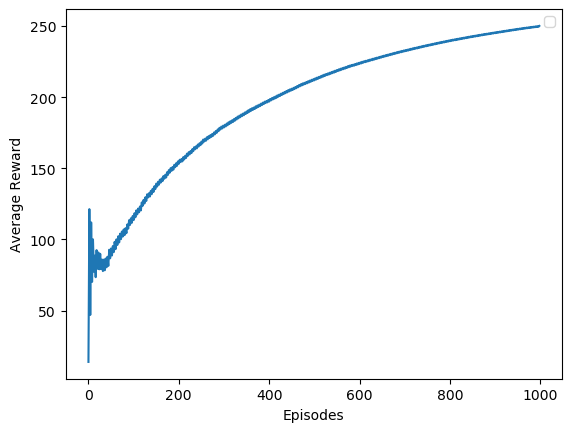

In [30]:
plt.plot(episodes,avg_reward)
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.legend()
plt.savefig("Avg_normal.png")

No handles with labels found to put in legend.


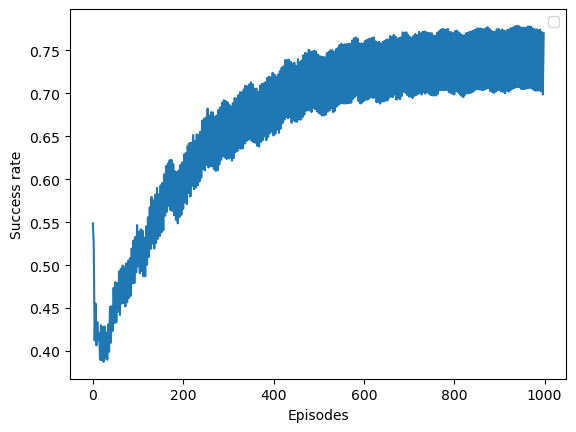

In [31]:
plt.plot(episodes,suc_rate)
plt.xlabel('Episodes')
plt.ylabel('Success rate')
plt.legend()
plt.savefig("suc_normal.png")

In [125]:
len(epsilon)

1000

No handles with labels found to put in legend.


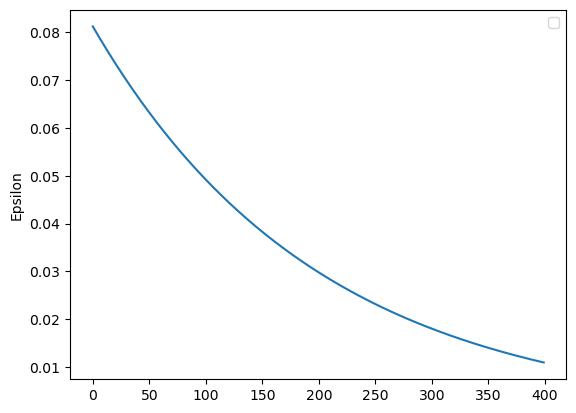

In [32]:
plt.plot(epsilon[500:900])
#plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.legend()
plt.savefig("epsilon_normal.png")

In [56]:
epsilon[500:600]

[0.0811640021330769,
 0.08075818212241151,
 0.08035439121179945,
 0.07995261925574046,
 0.07955285615946175,
 0.07915509187866444,
 0.07875931641927113,
 0.07836551983717477,
 0.07797369223798889,
 0.07758382377679894,
 0.07719590465791494,
 0.07680992513462537,
 0.07642587550895225,
 0.07604374613140748,
 0.07566352740075044,
 0.07528520976374668,
 0.07490878371492794,
 0.0745342397963533,
 0.07416156859737154,
 0.07379076075438468,
 0.07342180695061275,
 0.07305469791585968,
 0.07268942442628039,
 0.07232597730414898,
 0.07196434741762824,
 0.0716045256805401,
 0.0712465030521374,
 0.0708902705368767,
 0.07053581918419231,
 0.07018314008827135,
 0.06983222438783,
 0.06948306326589085,
 0.0691356479495614,
 0.06878996970981359,
 0.06844601986126451,
 0.06810378976195819,
 0.0677632708131484,
 0.06742445445908266,
 0.06708733218678724,
 0.0667518955258533,
 0.06641813604822402,
 0.0660860453679829,
 0.06575561514114299,
 0.06542683706543727,
 0.06509970288011008,
 0.06477420436570952,


In [57]:
q_table

defaultdict(<function __main__.<lambda>()>,
            {(9, 0, 0, 0): [91.16156166492583, 88.48133165642888],
             (0, 0, 0, 0): [91.27154784104732, 88.52143034257763],
             (19, 0, 0, 0): [91.04949229718942, 88.49138593310467],
             (29, 0, 0, 0): [90.93841890586829, 88.26712503531989],
             (39, 0, 0, 0): [90.83114398540826, 88.35966305840863],
             (49, 0, 0, 0): [90.72795984687136, 88.30241489162998],
             (59, 0, 0, 0): [90.62723461335692, 88.39399966287282],
             (69, 0, 0, 0): [90.52472565439504, 88.51489432200268],
             (79, 0, 0, 0): [90.420706545015, 88.39523769225903],
             (89, 0, 0, 0): [90.3522295755977, 87.79095613415146],
             (99, 0, 0, 0): [90.19016527211195, 88.03987180257656],
             (109, 0, 0, 0): [89.40050732077955, 87.29515578810324],
             (119, 0, 0, 0): [91.6794757049803, 88.92880060146807],
             (129, 0, 0, 0): [91.58366825948409, 89.0338811458372],
        